In [7]:
#Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [8]:
# Paso 2: Cargar y explorar el dataset
df = pd.read_csv('C:\\Users\\Benjamin Villacorta\\Documents\\Python\\CursoML\\archive\\bank_transactions_data_2.csv')  # Reemplaza con la ruta correcta

# Revisar estructura y primeras filas del dataset
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [9]:
# Celda 4: Imputación de valores nulos
# Imputación de valores nulos para columnas numéricas usando la mediana
num_columns = df.select_dtypes(include=[np.number]).columns
df[num_columns] = df[num_columns].apply(lambda x: x.fillna(x.median()), axis=0)

# Imputación de valores nulos para columnas categóricas usando el valor más frecuente (moda)
cat_columns = df.select_dtypes(include=['object']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.fillna(x.mode()[0]), axis=0)

# Verificar valores nulos restantes
print("Valores nulos por columna después de la imputación:\n", df.isnull().sum())


Valores nulos por columna después de la imputación:
 TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64


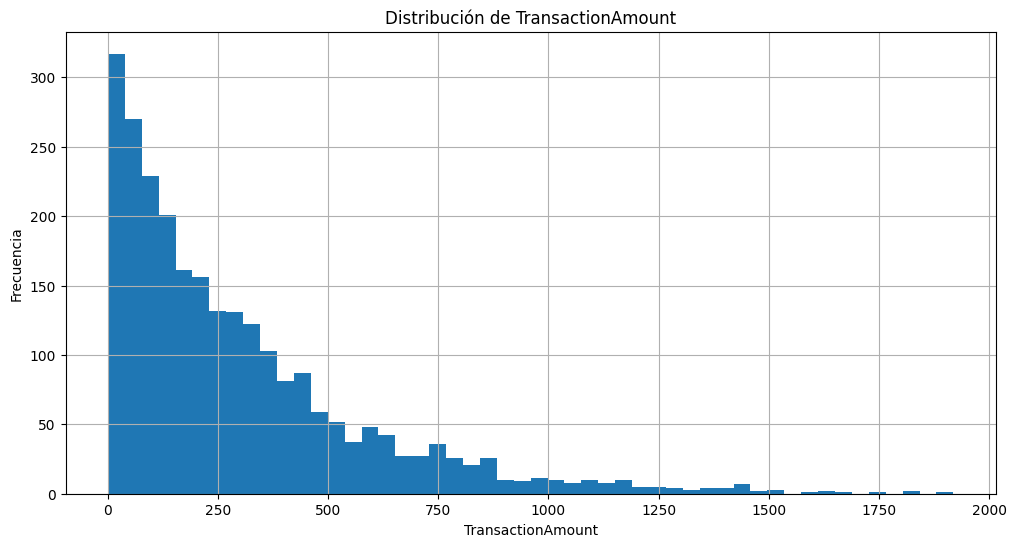

In [10]:
# Celda 5: Visualización de la distribución de variables numéricas
plt.figure(figsize=(12, 6))
df['TransactionAmount'].hist(bins=50)
plt.title('Distribución de TransactionAmount')
plt.xlabel('TransactionAmount')
plt.ylabel('Frecuencia')
plt.show()


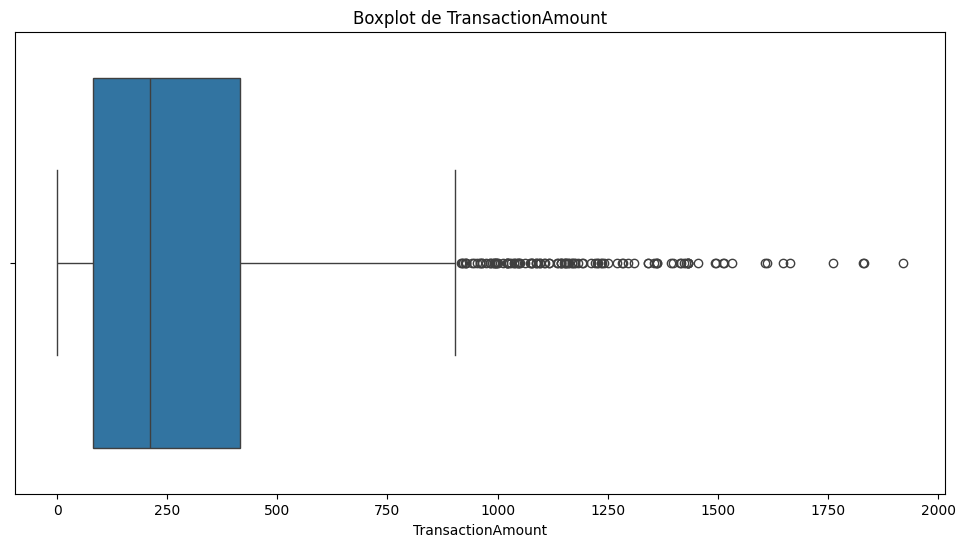

In [11]:
# Celda 6: Boxplot para observar outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['TransactionAmount'])
plt.title('Boxplot de TransactionAmount')
plt.show()


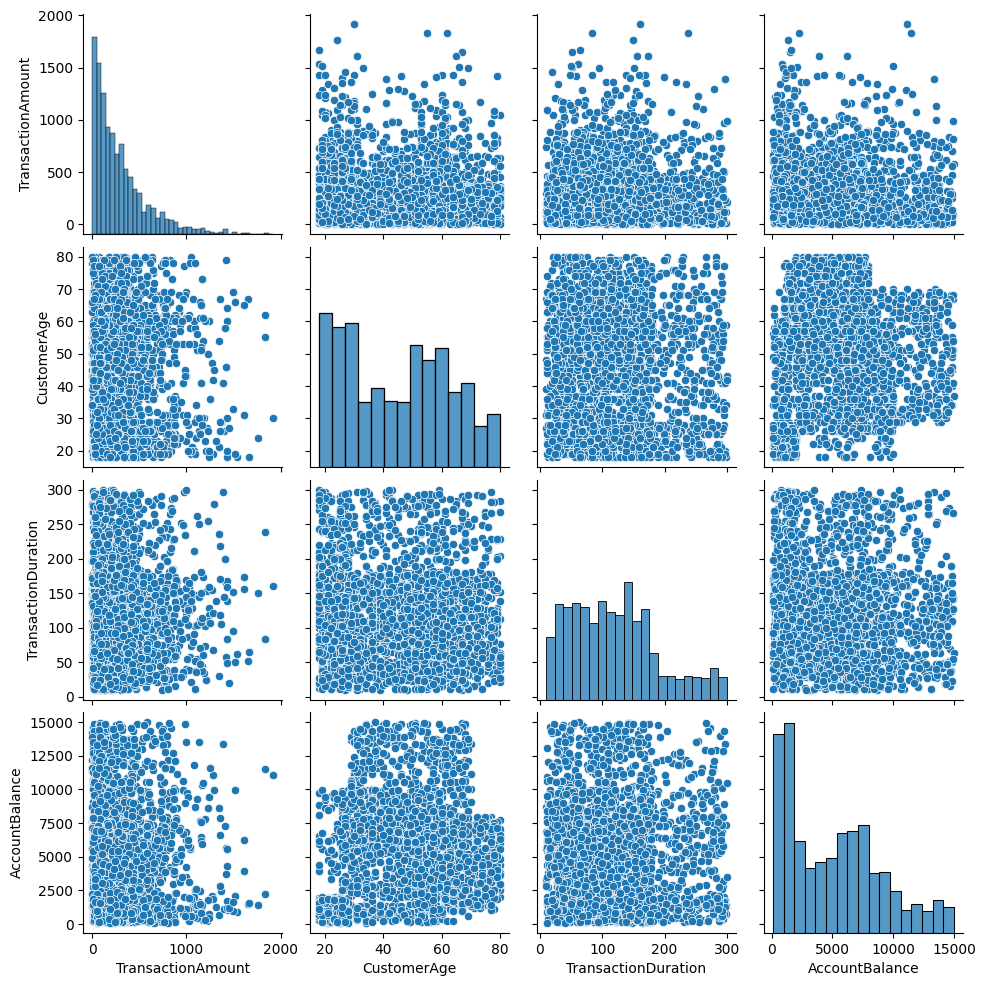

In [12]:
# Celda 7: Distribución bivariada de algunas variables numéricas
sns.pairplot(df, vars=['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'AccountBalance'])
plt.show()


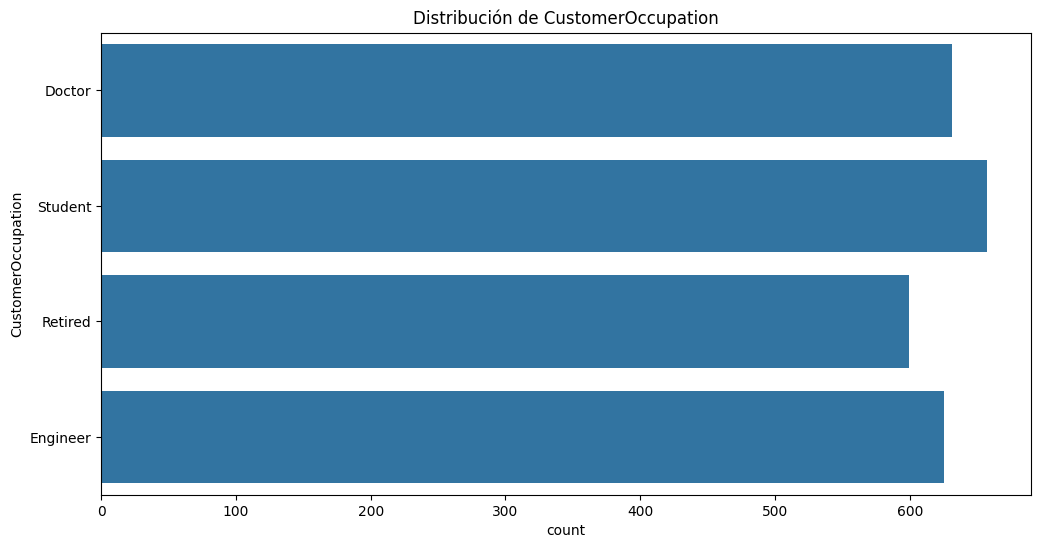

In [13]:
# Celda 8: Distribución de variables categóricas
plt.figure(figsize=(12, 6))
sns.countplot(y=df['CustomerOccupation'])
plt.title('Distribución de CustomerOccupation')
plt.show()


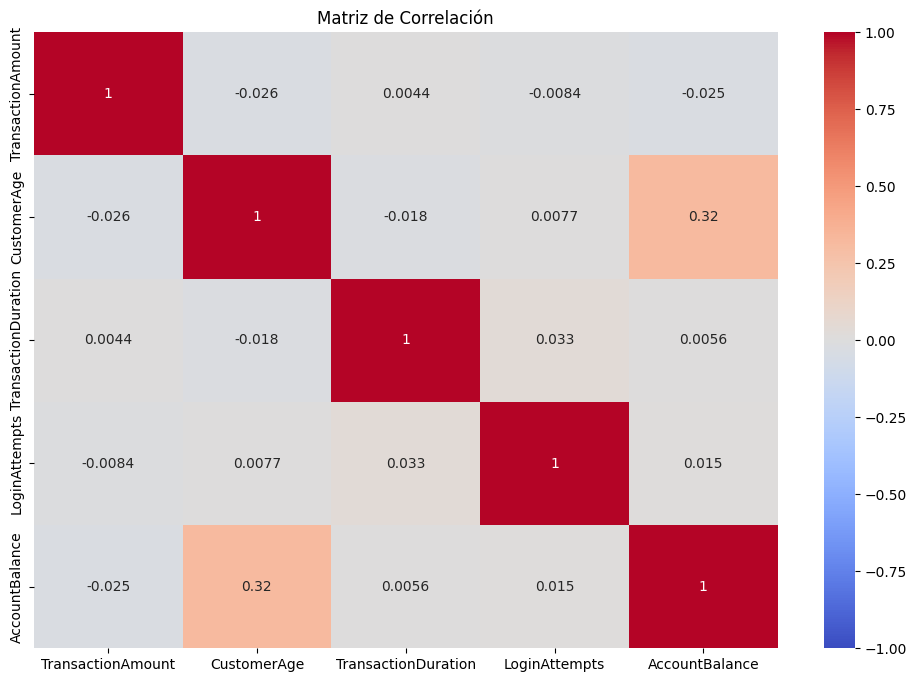

In [14]:
# Celda 9: Análisis de correlación
numeric_df = df.select_dtypes(include=[float, int])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()


In [15]:
# Celda 10: Tratamiento de outliers en 'TransactionAmount' y transformación logarítmica
Q1 = df['TransactionAmount'].quantile(0.25)
Q3 = df['TransactionAmount'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['TransactionAmount'] < (Q1 - 1.5 * IQR)) | (df['TransactionAmount'] > (Q3 + 1.5 * IQR)))]
df['TransactionAmount_log'] = np.log(df['TransactionAmount'] + 1)  # Transformación logarítmica


In [16]:
# Celda 11: Codificación de variables categóricas
df = pd.get_dummies(df, columns=['TransactionType', 'CustomerOccupation', 'Location', 'DeviceID', 'MerchantID', 'Channel'], drop_first=True)


In [18]:
# Celda 12: Asegurar conversión a datetime y extracción de características de fecha

# Convertir columnas de fecha a formato datetime (si no están en este formato ya)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'], errors='coerce')

# Extraer características de fecha de 'TransactionDate'
df['TransactionYear'] = df['TransactionDate'].dt.year
df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionDay'] = df['TransactionDate'].dt.day
df['TransactionHour'] = df['TransactionDate'].dt.hour

# Extraer características de fecha de 'PreviousTransactionDate'
df['PrevTransactionYear'] = df['PreviousTransactionDate'].dt.year
df['PrevTransactionMonth'] = df['PreviousTransactionDate'].dt.month
df['PrevTransactionDay'] = df['PreviousTransactionDate'].dt.day
df['PrevTransactionHour'] = df['PreviousTransactionDate'].dt.hour

# Crear la columna 'DaysSincePrevious' calculando la diferencia de días entre las dos fechas
df['DaysSincePrevious'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.days

# Verificar las primeras filas para asegurarse de que la extracción fue exitosa
print(df[['TransactionYear', 'TransactionMonth', 'TransactionDay', 'TransactionHour',
          'PrevTransactionYear', 'PrevTransactionMonth', 'PrevTransactionDay', 'PrevTransactionHour', 
          'DaysSincePrevious']].head())


   TransactionYear  TransactionMonth  TransactionDay  TransactionHour  \
0             2023                 4              11               16   
1             2023                 6              27               16   
2             2023                 7              10               18   
3             2023                 5               5               16   
4             2023                10              16               17   

   PrevTransactionYear  PrevTransactionMonth  PrevTransactionDay  \
0                 2024                    11                   4   
1                 2024                    11                   4   
2                 2024                    11                   4   
3                 2024                    11                   4   
4                 2024                    11                   4   

   PrevTransactionHour  DaysSincePrevious  
0                    8               -573  
1                    8               -496  
2                   

In [19]:
# Celda 13: Eliminación de columnas irrelevantes
cols_to_drop = ['TransactionID', 'AccountID', 'TransactionDate', 'PreviousTransactionDate', 'IP Address']
df.drop(columns=cols_to_drop, inplace=True)


In [20]:
# Celda 14: Separación de variables predictoras y variable objetivo
X = df.drop(columns=['TransactionAmount'])
y = df['TransactionAmount']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Celda 15: Entrenamiento y evaluación con validación cruzada
model = LinearRegression()

# Validación cruzada con KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print("Cross-Validated MSE Scores:", -cv_scores)
print("Mean MSE (Cross-Validation):", -np.mean(cv_scores))


Cross-Validated MSE Scores: [4.46397845e+19 2.83558975e+20 1.09391009e+20 3.56212218e+18
 6.55256930e+19]
Mean MSE (Cross-Validation): 1.013355168521946e+20


In [22]:
# Celda 16: Ajuste del modelo y evaluación en el conjunto de prueba
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error en prueba: {mse}")
print(f"R^2 Score en prueba: {r2}")


Mean Squared Error en prueba: 22812.773167446332
R^2 Score en prueba: 0.5269739383022192


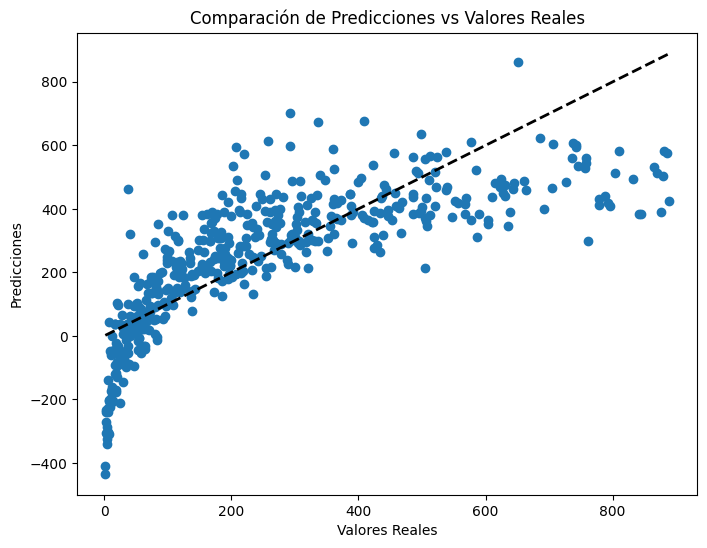

In [23]:
# Celda 17: Visualización de resultados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()
